# Notebook 3: Decision AI and Terrain

In this notebook, we explore developments to `battlesim` from version 0.3.4 including the new `Terrain` object and how terrains now impact the simulation.

### Requirements:

- `numpy`
- `pandas`
- `matplotlib`
- `scipy.stats`
- `numba`

In [1]:
import sys
sys.path.insert(0,"../")
# import
import battlesim as bsm

As before, we create a `Battle` object which is the main and only object you need to know about in the package, unless you wish to tweak some things under the hood.

In [2]:
bat = bsm.Battle("../datasets/starwars-clonewars.csv")
bat

bsm.Battle(init=False)

You may notice that a `T_` attribute for terrain is now present, and created, but not initialized:

In [3]:
bat.T_

Terrain(init=False, type='None', dim=(0, 10, 0, 10), resolution=0.100)

In addition, we have implemented **bounds** in the arena for the first time. This prevents units from leaving a certain bounds, which the `hit_and_run` decision AI had the tendency to simply keep running back and back, making it **too powerful** compared to basic aggressive tactics.

By default we set this to $(0, 10, 0, 10)$, corresponding to left, right, up and down respectively.

Bounds are checked at each time step in the simulation, by simply moving unit positions of units outside the box back into it:

\begin{equation}
B(x, y)=\begin{cases}
X_{min} & x < X_{min} \\
X_{max} & x > X_{max} \\
Y_{min} & y < Y_{min} \\
Y_{max} & y > Y_{max} 
\end{cases}
\end{equation}

Assuming movement speeds are relatively low, this keeps every unit in the plane.

In [4]:
bat.bounds_

(0, 10, 0, 10)

To modify these methods, make use of the `obj.set_bounds` and `obj.apply_terrain` methods. Note that setting the bounds or terrain before an *army* is initialized may cause clashes with the position-assignment of the units. What this means is that the unit spawner MUST spawn all units within the bounds before simulation starts. In practice, this just gives you a warning:

In [5]:
bat.set_bounds((-10, 20, -10, 20))

../battlesim/battle.py:189: UserWarning: bounds (-10, 20, -10, 20) set before units are initialised - some may be out-of-bounds
  warnings.warn("bounds {} set before units are initialised - some may be out-of-bounds".format(b), UserWarning)


bsm.Battle(init=False)

When applying a terrain, we have a few options as to how we want it to look:

1. Use `None`, this tells the battle object that we want no terrain - i.e flat
2. Use `grid`, this makes a map of little color squares that have height
3. Use `contour`, this makes a map of filled contour lines that have height. In my opinion this one looks the best.

However, a terrain cannot be generated *until army groups have been defined*. Otherwise how can the bounds be properly determined?

In [6]:
bat.create_army([("Clone Trooper", 20), ("B1 battledroid", 50)])
bat.composition_

,unit,allegiance,n,position,init_ai,rolling_ai,decision_ai
0,clone trooper,Republic,20,"norm (0.0, 0.0)",nearest,nearest,aggressive
1,b1 battledroid,CIS,50,"norm (2.0, 2.0)",nearest,nearest,aggressive


Did this change the boundary?

In [7]:
bat.bounds_

(-4.0, 4.0, -2.0, 5.0)

So calls to `create_army` will try and re-assign new boundaries respective of the units. However they might be a bit *hemmed in*.

Note that, by using the `None` as input, I am essentially defining a flat terrain:

In [8]:
bat.apply_terrain(None)

bsm.Battle(init=True, n_armies=2, simulated=False)

A call to `apply_terrain` does however generate a map, which can be accessed through the height `Z_` attrbiute in the terrain, which only appears once the simulation has been called:

In [9]:
bat.T_.Z_

Now we modify the position of the army groups using `apply_position`, which should change the natural boundaries:

In [10]:
bat.apply_position([
    dict(name="normal", loc=-2., scale=2.),
    dict(name="normal", loc=5., scale=2.)
])

bsm.Battle(init=True, n_armies=2, simulated=False)

In [11]:
bat.bounds_

(-6.0, 11.0, -8.0, 9.0)

Once again, we have modifications in the 'boundary' to reflect the changes. Note that calls to `T_.generate()` to make a terrain are also done in the `simulate()` and `simulate_k()` functions, which is still in working progress to figure out how to effectively incorporate functions $z=f(x,y)$.

Now by checking the composition, we see that by default our units will target the nearest enemy which is good, but we have a new option called `decision_ai`. We currently have two options:

1. `aggressive`: we aggressively pursue the enemy
2. `hit_and_run`: we perform a hit-and-run approach

This is achieved through the `set_decision_ai` function:

In [12]:
bat.set_decision_ai("aggressive")

bsm.Battle(init=True, n_armies=2, simulated=False)

By default, `aggressive` is chosen for each army group unless overrided.

In [13]:
bat.composition_

,unit,allegiance,n,position,init_ai,rolling_ai,decision_ai
0,clone trooper,Republic,20,"norm (-2.0, -2.0)",nearest,nearest,aggressive
1,b1 battledroid,CIS,50,"norm (5.0, 5.0)",nearest,nearest,aggressive


In [14]:
bat.T_

Terrain(init=False, type='None', dim=(-6.0, 11.0, -8.0, 9.0), resolution=0.100)

I think we're ready to simulate...

In [15]:
F = bat.simulate()

In [16]:
bat.sim_jupyter()

## With Terrain Modification

Terrains currently serve to **reduce the movement speed** of units by up to 50% when moving on a hill. To specify a terrain, use `apply_terrain` and use either `grid` or `contour`.

Mathematically, movement calculations are *currently* determined at timestep $t$ with $u \in [x, y]$ as:

\begin{align}
\dot{u}_{i,t} \approx s_i \left(1-\frac{z_{i}}{2}\right) \frac{\delta u_{i,t}}{||\delta u_{i,t} ||}
\end{align}

where $s_i$ is the unit base speed, $\delta u_i$ is the directional derivative with respect to it's enemy, $||\delta u_i ||$ is the distance of unit $i$ from the enemy $j$, and $z_{i}$ is the height measured at the node nearest to $u_i$. indices of $z$ are determined as:

\begin{align}
z_{ind}=\arg \min \left|u_{i,t}-\Omega \right|
\end{align}

where $\Omega$ is the meshgrid domain. Note that $z$ can be from a function defined by the user as $z=f(\Omega)$, or generated from random Gaussian multivariate distributions:

\begin{align}
z_{i,d} \sim \mathcal{N}(\mathbf{\mu}, \mathbf{\Sigma})
\end{align}

where $\mathbf{\Sigma}$ is the covariance matrix of shape $(2,2)$. Given $d$-Gaussian densities where bounds $\Omega \in [X_{min}, X_{max}, Y_{min}, Y_{max}]$ are defined, we randomly sample parameters $\mathbf{\mu}$ and $\mathbf{\Sigma}$:

\begin{align}
\mu_x \sim \mathcal{U}(0, X_{max}-X_{min}) + X_{min} \\
\mu_y \sim \mathcal{U}(0, Y_{max}-Y_{min}) + Y_{min} \\
\Sigma_{xx} \sim \mathcal{U}(1, 2) \, s_x \\
\Sigma_{yy} \sim \mathcal{U}(1, 2) \, s_y \\
\Sigma_{xy} \equiv \Sigma_{yx} \sim \mathcal{U}(0, 1)\, \mathcal{C}(0, 1)
\end{align}

where:

\begin{align}
\mathcal{C}(0, 1)=\begin{cases}
-1 & \mathcal{C} < 0 \\
1 & \mathcal{C} >= 0
\end{cases}
\end{align}

and acts to flip the direction of the gaussian ellipse. Note that scaling parameters $s_x$ and $s_y$ are pre-decided by slope $m$ and intercept $b$ such that as $d$ increases, $s_x$ and $s_y$ decrease. These are determined using a linear model:

\begin{align}
s_x=\frac{(X_{max}-X_{min})}{(X_{max}-X_{min})m + b} \\
s_y=\frac{(Y_{max}-Y_{min})}{(Y_{max}-Y_{min})m + b}
\end{align}

Slope $m$ and intercept $b$ are calculated from the following range $I \in [0, 300]$ and $J \in [5, 2]$ as $J=Im +b$ using linear degree. Once all this is done, the probability densities at each point $(i, j)$ are summed and scaled using **minmax** scaling in the range $[0, 1]$:

\begin{align}
\bar{z}_i = \sum_d z_{i, d} \\
z_i = \frac{\bar{z}_i - \min \bar{z}_i}{\max \bar{z}_i - \min \bar{z}_i}
\end{align}

In [17]:
bat.apply_terrain("contour")

bsm.Battle(init=True, n_armies=2, simulated=True)

In [18]:
bat.T_

Terrain(init=True, type='contour', dim=(-6.0, 11.0, -8.0, 9.0), resolution=0.100)

Now if we re-run:

In [19]:
F = bat.simulate()
bat.sim_jupyter()

A *marked difference* in performance, the units on the hill move substantially slower, giving the other team a chance to pick off the enemy units in a more stream-like fashion.

Notice that with each re-run the hill(s) should spawn in different locations.

## Using Hit-and-Run

Let's see how the Republic fares when we incorporate the `hit_and_run` AI:

In [20]:
bat.set_decision_ai(["hit_and_run","aggressive"])

bsm.Battle(init=True, n_armies=2, simulated=True)

In [21]:
F = bat.simulate()
bat.sim_jupyter()

You will notice that the Republic performs **substantially better** using this more complex AI path than simple *aggressive* strategies.

Let's perform a test to see if this AI strategy alone can improve outcomes using `simulate_k`.

This can be found very elegantly since most of the functions in `Battle` return self which means we can *function chain*:

In [32]:
Tests = [
    (bsm.Battle("../datasets/starwars-clonewars.csv")
         .create_army([("B1 battledroid", 70), ("Clone Trooper", 25)])
         .apply_position([dict(name="normal", loc=10.), dict(name="normal", loc=2., scale=2.)])
         .set_bounds((-10, 20, -10, 20))
         .apply_terrain("contour")
         .set_decision_ai(option)
         .simulate_k(50)
    ) for option in [("aggressive","hit_and_run"), "aggressive"]
]

For this, we will use `seaborn` library for plotting and `pandas` to preprocess the data a bit into the format that seaborn likes.

In [33]:
import pandas as pd

In [34]:
# melt the columns and add a 'run' column, then join
C = pd.concat([T.melt(var_name="team",value_name="number of units remaining").assign(Run=r) 
 for T,r in zip(Tests, ["w/ hit and run", "w/o hit and run"])])

In [35]:
import seaborn as sns

### Takeaway: AI matters

Look at the difference! With hit and run, The Republic always wins with some units left over, whereas in a straight-up aggressive fight, the droids win with half of their forces remaining.

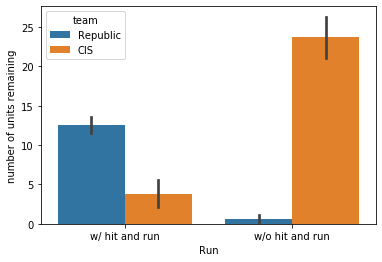

In [36]:
# plot
_ = sns.barplot(data=C,x="Run",y="number of units remaining",hue="team")

This is the end to the third notebook.